In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import keras
from sklearn.model_selection import train_test_split

%matplotlib inline

In [10]:
import cv2

In [11]:
!pip install tensorflow --quiet

In [12]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [13]:
!pip install keras cython h5py --quiet

In [14]:
data_path = './Data/fer2013.csv'
image_size = (48,48)


In [15]:
data=pd.read_csv(data_path)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [17]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [18]:
data['emotion'].value_counts(sort=False).reset_index()

,index,emotion
0,0,4953
1,1,547
2,2,5121
3,3,8989
4,4,6077
5,5,4002
6,6,6198


In [19]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


In [20]:
def pics_from_row(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    pic = np.array(pixels.split())
    pic = pic.reshape(48,48)
    picture = np.zeros((48,48,3))
    picture[:,:,0] = pic
    picture[:,:,1] = pic
    picture[:,:,2] = pic
    return np.array([picture.astype(np.uint8),emotion])

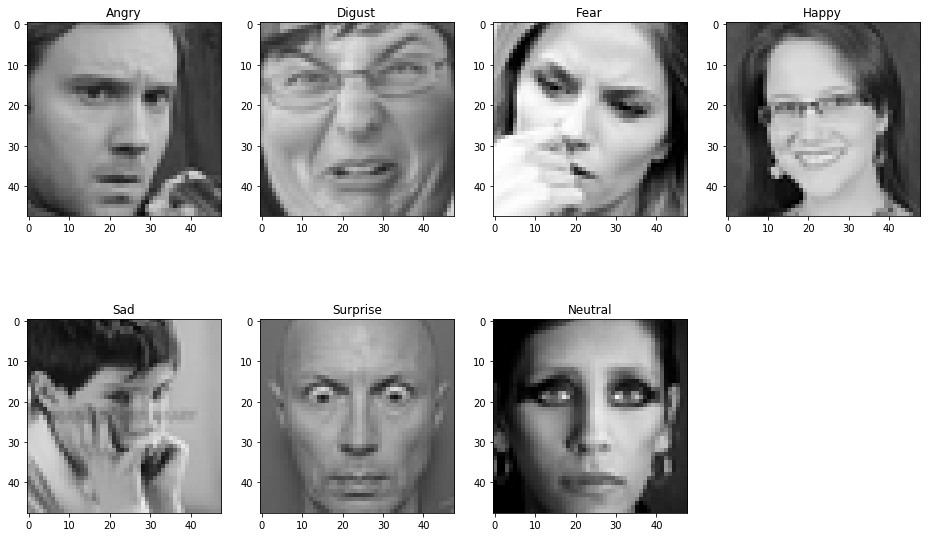

In [21]:
plt.figure(0,figsize=(16,10))
for i in range (1,8):
    face = data[data['emotion']== i-1].iloc[0]
    pic = pics_from_row(face)
    plt.subplot(2,4,i)
    plt.imshow(pic[0])
    plt.title(pic[1])
plt.show()

In [22]:
pixels = data ['pixels'].tolist()
width,height = 48,48
faces = []
for i in pixels: 
    face = [int(pixel) for pixel in i.split(' ')]
    face = np.asarray(face).reshape(width,height)
    face = cv2.resize(face.astype('uint8'),image_size)
    face = face.astype('float32')
    faces.append(face)
faces = np.asarray(faces)
faces = np.expand_dims(faces,-1)

In [23]:
emotions = pd.get_dummies(data['emotion']).values

In [24]:
def preprocessor (x,v2=True):
      x = x.astype('float32')
      x = x / 255.0
      if v2:
            x = x - 0.5
            x = x*2.0
            return x
faces = preprocessor(faces)

In [25]:
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

split data into test and train dataframes

In [26]:
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size = 0.3,shuffle = True)

In [27]:
np.save('faces_train',X_train)

In [28]:
np.save('faces_test',X_test)

In [29]:
np.save('emotion_train',y_train)

In [30]:
np.save('emotion_test',y_test)

In [162]:
#y_train = keras.utils.to_categorical(y_train, 7) # second value defines how many categories we have
#y_test = keras.utils.to_categorical(y_test, 7)

In [31]:
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Activation, Dense, Flatten
from keras.models import Sequential
from keras.activations import relu, softmax

In [32]:
y_train[0]

array([1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [33]:
keras.backend.image_data_format()

'channels_last'

In [34]:
X_train.shape

(25120, 48, 48, 1)

In [35]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) # this adds a 1 column to X_train and X_test
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1) # which is for grayscale 

In [36]:
X_train.shape

(25120, 48, 48, 1)

In [37]:
y_train.shape

(25120, 7)

In [38]:
cnn = Sequential([
    Conv2D(50, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(48, 48, 1)),
#     Conv2D(16, (3, 3), activation='relu'),
#     Dropout(.25),
    MaxPool2D(),
    Flatten(),
    Dense(64, activation='relu'),
#     Dropout(.25),
    Dense(64, activation='softmax'),
    Dense(7, activation='softmax')
    
])

W0910 19:26:26.758280 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0910 19:26:26.799276 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0910 19:26:26.911086 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0910 19:26:26.934028 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d inste

In [39]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 50)        500       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26450)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1692864   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 1,697,979
Trainable params: 1,697,979
Non-trainable params: 0
_________________________________________________________________


In [191]:
cnn_8 = Sequential([
    Conv2D(8, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(48, 48, 1)),
     Conv2D(16, (3, 3), activation='relu'),
     Dropout(.25),
    MaxPool2D(),
    Flatten(),
    Dense(64, activation='relu'),
     Dropout(.25),
    Dense(7, activation='softmax')
])

In [143]:
cnn_8.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 44, 44, 8)         208       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 42, 42, 16)        1168      
_________________________________________________________________
dropout_15 (Dropout)         (None, 42, 42, 16)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 7056)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                451648    
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
__________

In [40]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

W0910 19:26:37.878952 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0910 19:26:37.886521 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [192]:
cnn_8.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [216]:
cnn.fit(X_train, y_train, validation_split=.3, epochs=100)

Train on 17584 samples, validate on 7536 samples
Epoch 1/100
17584/17584 [==============================] - 25s 1ms/step - loss: 1.5426 - acc: 0.3837 - val_loss: 1.5996 - val_acc: 0.3540
Epoch 2/100
17584/17584 [==============================] - 23s 1ms/step - loss: 1.4671 - acc: 0.4216 - val_loss: 1.5707 - val_acc: 0.3857
Epoch 3/100
17584/17584 [==============================] - 23s 1ms/step - loss: 1.3814 - acc: 0.4572 - val_loss: 1.5401 - val_acc: 0.4029
Epoch 4/100
17584/17584 [==============================] - 22s 1ms/step - loss: 1.3019 - acc: 0.4828 - val_loss: 1.5422 - val_acc: 0.4086
Epoch 5/100
17584/17584 [==============================] - 23s 1ms/step - loss: 1.2096 - acc: 0.5171 - val_loss: 1.5726 - val_acc: 0.4009
Epoch 6/100
17584/17584 [==============================] - 22s 1ms/step - loss: 1.1320 - acc: 0.5441 - val_loss: 1.5705 - val_acc: 0.4096
Epoch 7/100
17584/17584 [==============================] - 22s 1ms/step - loss: 1.0547 - acc: 0.5769 - val_loss: 1.5944 - v

In [196]:
cnn_8.fit(X_train, y_train, validation_split=.3, epochs=3)

Train on 17584 samples, validate on 7536 samples
Epoch 1/3
17584/17584 [==============================] - 16s 927us/step - loss: 1.2348 - acc: 0.5340 - val_loss: 1.3542 - val_acc: 0.4827
Epoch 2/3
17584/17584 [==============================] - 17s 940us/step - loss: 1.1246 - acc: 0.5755 - val_loss: 1.3756 - val_acc: 0.4797
Epoch 3/3
17584/17584 [==============================] - 17s 946us/step - loss: 1.0143 - acc: 0.6226 - val_loss: 1.3536 - val_acc: 0.4886


In [2]:
conda install h5py

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.
Solving environment: done
WARNING conda.core.package_cache_data:_make_single_record(350): Encountered corrupt package tarball at /Users/cyt.mead/anaconda3/pkgs/certifi-2019.6.16-py36_1.tar.bz2. Conda has removed it, but you need to re-run conda to download it again.

## Package Plan ##

  environment location: /Users/cyt.mead/anaconda3

  added / updated specs:
    - h5py


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.5.15  |                1         133 KB
    certifi-2019.6.16          |           py36_1         155 KB
    conda-4.7.11               |           py36_0         3.0 MB
    ----------------------------

In [4]:
pip install coremltools 

     |████████████████████████████████| 3.1MB 3.4MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [50]:
from keras.models import load_model
import coremltools

In [51]:
cnn.save('fifa_emo.h5')

In [52]:
output_labels = ['0', '1', '2', '3', '4', '5', '6']
fifa_emo = coremltools.converters.keras.convert('fifa_emo.h5', input_names=['image'], output_names=['output'], 
                                                   class_labels=output_labels, image_input_names='image')

fifa_emo.save('fifa_emo.mlmodel')

0 : conv2d_1_input, <keras.engine.input_layer.InputLayer object at 0x1a427bd860>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x1a427bd828>
2 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x11063a1d0>
3 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x1a427bdc88>
4 : flatten_1, <keras.layers.core.Flatten object at 0x1a427d8128>
5 : dense_1, <keras.layers.core.Dense object at 0x1a427d80b8>
6 : dense_1__activation__, <keras.layers.core.Activation object at 0x1a4284d3c8>
7 : dense_2, <keras.layers.core.Dense object at 0x1a427f2780>
8 : dense_2__activation__, <keras.layers.core.Activation object at 0x1a4284d278>
9 : dense_3, <keras.layers.core.Dense object at 0x1a42813d68>
10 : dense_3__activation__, <keras.layers.core.Activation object at 0x1a427bd7b8>


In [212]:
loss, accuracy = cnn.evaluate(X_test, y_test)

10767/10767 [==============================] - 3s 286us/step


In [197]:
loss_x, accuracy_x = cnn_8.evaluate(X_test, y_test)

10767/10767 [==============================] - 2s 219us/step


In [213]:
accuracy

0.31642983190758905

In [198]:
accuracy_x

0.49874616887694095

In [36]:
mlp = Sequential([
    Dense(24, input_shape=(28,28,1), activation='relu'), # documentation of activations: https://keras.io/activations/
    Flatten(),
    Dense(10, activation='softmax')
])

W0905 18:17:05.786782 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 18:17:05.831677 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 18:17:05.851822 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [37]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28, 28, 24)        48        
_________________________________________________________________
flatten_1 (Flatten)          (None, 18816)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                188170    
Total params: 188,218
Trainable params: 188,218
Non-trainable params: 0
_________________________________________________________________


In [38]:
mlp.compile(optimizer=keras.optimizers.SGD(), 
           loss=keras.losses.categorical_crossentropy, #we are doing a multi-class classification; minimize loss
           metrics=['accuracy'])

W0905 18:17:12.809637 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0905 18:17:12.817721 140735758738304 deprecation_wrapper.py:119] From /Users/cyt.mead/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [39]:
(X_train, y_train), (X_test, y_test) = './Data/fer2013.csv'

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) # this adds a 1 column to X_train and X_test
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1) # which is for grayscale 

ValueError: too many values to unpack (expected 2)

In [39]:
mlp.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

NameError: name 'X_train' is not defined